# Анализ и преобразование данных для обучения моделей

# <a id="0">Содержание</a>

- <a href="#1">План работы на данном этапе</a>
- <a href="#2">Кластеризация таргета</a>  
- <a href="#3">Нормирование числовых данных</a>  
- <a href="#4">Создание бинарного целевого признака</a>  
- <a href="#5">Статистический анализ данных</a>  
- <a href="#6">Отбор признаков</a>  
- <a href="#7">Создание эмбединга признаков</a>  
- <a href="#8">Выводы</a>  

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from torch import nn
from torch import optim
import torch
from torch.utils.data import DataLoader, TensorDataset
import tqdm

import utils.stepwiseSelection as ss
from utils.utils import categorize_table, Encoder, Decoder
import pickle

# <a id="1">План работы на данном этапе</a>

1. Загрузка данных и преобразование в тип categories категориальных столбцов
2. Проверка гипотезы о возможнсоти выделения кластеров в таргете
3.  Преобразование таргетов из таблицы feedback_preprocessed.csv в два столбца (в первому отображается вероятнсоть перехода клиента по ссылке, во втором бинарное значение 1/0 т.е. перешёл или не перешёл по ссылке)
4.   Првоерка корреляции числовых признаков и статистической значимости их коэффициентов в логистической регрессии
5.  Преобразование категориальных данных при помощи OneHotEncoding
6.   Проверка гипотезы о возможности отбора признаков с помощью информационного критерия Акайке и проверка данных на сингулярность
7.   Отбор признаков при помощи классификационных и регрессионных деревьев (классификационных для бинарного таргета, регрессионных для таргета с вероятностью)
8.   Сохранение данных в форме OneHotEncoding для значимых категорий (отобранных на бэггинге деревьев)
9.   Понижение размерности данных в форме OneHotEncoding при помощи EncoderDecoder архитектуры на основе полносвязанной нейронной сети.
10.   Сохранения обучающих данных в форме эмбеддингов
11.   Создание функции, преобразующей входную таблицу с данными в эмбеддинги

In [2]:
# Загрузим предобработанные файлы
feedback = pd.read_csv(r'../preprocessed/feedback_preprocessed.csv')
behaviour = pd.read_csv(r'../preprocessed/behaviour_2023_preprocessed.csv')

In [3]:
categorical_columns = ['OKVED', 'UnitTypeCategory', 'ActivityArea', 'Service',
                       'Support', 'TransportationType', 'BeginMonth', 'EndMonth',
                       'IsHoliday', 'IsWeekend']

behaviour = categorize_table(behaviour) # функция преобразует категориальные данные в тип categories
#проверяем что в категориальных данных значения различны (в одной колонке не находится только одна категория)
for column_name in categorical_columns:
    print(behaviour[column_name].value_counts())

OKVED
0.0         12447
469000.0     4064
466900.0     1117
464900.0     1052
453101.0      938
            ...  
612000.0        1
464932.0        1
900400.0        1
151101.0        1
107239.0        1
Name: count, Length: 847, dtype: int64
UnitTypeCategory
2    48293
0    12744
1     5822
Name: count, dtype: int64
ActivityArea
0.0      28893
3.0       2442
12.0      1280
6.0        834
10.0       708
         ...  
213.0        2
208.0        2
204.0        2
219.0        2
220.0        2
Name: count, Length: 221, dtype: int64
Service
0.0     45591
3.0      4420
2.0      4369
4.0      2569
5.0      2035
7.0      1644
9.0      1417
6.0      1339
10.0      972
8.0       704
11.0      380
14.0      312
12.0      187
17.0      128
15.0      111
18.0       96
13.0       88
19.0       86
21.0       71
24.0       46
25.0       40
35.0       38
33.0       34
47.0       30
16.0       24
23.0       22
27.0       13
22.0       11
30.0        9
32.0        8
26.0        7
38.0        7
46.0    

m:\venvs\pec_venv\lib\site-packages\utils\utils.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[467306.0, 467306.0, 467306.0, 467306.0, 467306.0, ..., 0.0, 0.0, 0.0, 0.0, 0.0]
Length: 66859
Categories (847, float64): [0.0, 10100.0, 11100.0, 11101.0, ..., 960202.0, 960300.0, 960400.0, 960900.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  behaviour.loc[:, 'OKVED']  = behaviour.loc[:, 'OKVED'].astype("category")
m:\venvs\pec_venv\lib\site-packages\utils\utils.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 2.0, 3.0, 1.0, 2.0, ..., 0.0, 119.0, 10.0, 119.0, 10.0]
Length: 66859
Categories (221, float64): [0.0, 1.0, 2.0, 3.0, ..., 217.0, 218.0, 219.0, 220.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  behaviour.loc[:, 'ActivityArea'] = beha

### Проверяем распределение таргета в таблице feedback

array([[<Axes: title={'center': 'nClick'}>,
        <Axes: title={'center': 'nOpen'}>],
       [<Axes: title={'center': 'nSend'}>, <Axes: >]], dtype=object)

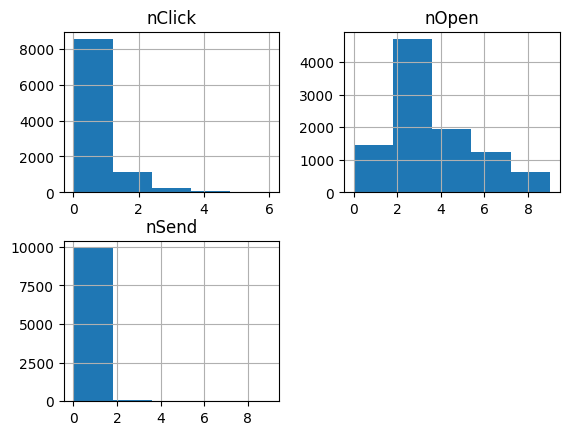

In [4]:
feedback.loc[:, 'nClick':'nSend'].hist(bins = 5)

# <a id="2">Кластеризация таргета</a>

### Проверяем гипотезу о том, что 3 колонки таргета можно преобразовать в один признак при помощи кластеризации

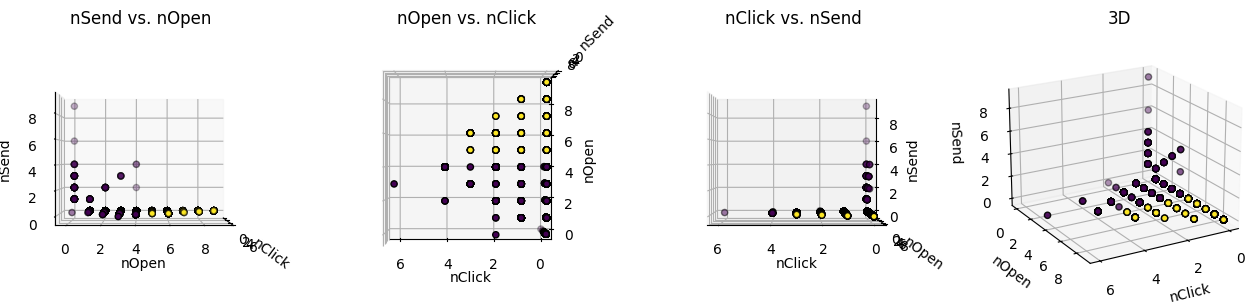

In [5]:
# Создаем модель KMeans для кластеризации с 2 кластерами
cluster_model = KMeans(n_clusters=2)

# Создаем фигуру размером 16x16 дюймов
fig = plt.figure(figsize=(16, 16))

# Название для первого графика
title = "nSend vs. nOpen"
# Создаем 3D subplot для первого графика с заданными параметрами вращения (elev=0, azim=0)
ax = fig.add_subplot(1, 4, 1, projection="3d", elev=0, azim=0)
# Обучаем модель на данных, используя колонки от 'nClick' до 'nSend'
cluster_model.fit(feedback.loc[:, 'nClick':'nSend'].values)
# Получаем метки кластеров
labels = cluster_model.labels_
# Отображаем точки данных в 3D пространстве, используя метки кластеров для цветовой схемы
ax.scatter(feedback.iloc[:, 2], feedback.iloc[:, 3], feedback.iloc[:, 4], c=labels, edgecolor="k")
# Устанавливаем подписи осей
ax.set_xlabel("nClick")
ax.set_ylabel("nOpen")
ax.set_zlabel("nSend")
# Устанавливаем заголовок графика
ax.set_title(title)

# Название для второго графика
title = "nOpen vs. nClick"
# Создаем 3D subplot для второго графика с другими параметрами вращения (elev=270, azim=270)
ax = fig.add_subplot(1, 4, 2, projection="3d", elev=270, azim=270)
# Отображаем точки данных в 3D пространстве, используя метки кластеров для цветовой схемы
ax.scatter(feedback.iloc[:, 2], feedback.iloc[:, 3], feedback.iloc[:, 4], c=labels, edgecolor="k")
# Устанавливаем подписи осей
ax.set_xlabel("nClick")
ax.set_ylabel("nOpen")
ax.set_zlabel("nSend")
# Устанавливаем заголовок графика
ax.set_title(title)

# Название для третьего графика
title = "nClick vs. nSend"
# Создаем 3D subplot для третьего графика с другими параметрами вращения (elev=0, azim=90)
ax = fig.add_subplot(1, 4, 3, projection="3d", elev=0, azim=90)
# Отображаем точки данных в 3D пространстве, используя метки кластеров для цветовой схемы
ax.scatter(feedback.iloc[:, 2], feedback.iloc[:, 3], feedback.iloc[:, 4], c=labels, edgecolor="k")
# Устанавливаем подписи осей
ax.set_xlabel("nClick")
ax.set_ylabel("nOpen")
ax.set_zlabel("nSend")
# Устанавливаем заголовок графика
ax.set_title(title)

# Название для четвертого графика
title = "3D"
# Создаем 3D subplot для четвертого графика с другими параметрами вращения (elev=20, azim=60)
ax = fig.add_subplot(1, 4, 4, projection="3d", elev=20, azim=60)
#cluster_model.fit(feedback.loc[:, 'nClick':'nSend'].values)
#labels = cluster_model.labels_
# Отображаем точки данных в 3D пространстве, используя метки кластеров для цветовой схемы
ax.scatter(feedback.iloc[:, 2], feedback.iloc[:, 3], feedback.iloc[:, 4], c=labels, edgecolor="k")
# Устанавливаем подписи осей
ax.set_xlabel("nClick")
ax.set_ylabel("nOpen")
ax.set_zlabel("nSend")
# Устанавливаем заголовок графика
ax.set_title(title)

# Настраиваем расстояние между подграфиками
plt.subplots_adjust(wspace=0.25, hspace=0.25)
# Отображаем графики
plt.show()

### **Вывод по кластеризации**:
Похоже, что кластеризация показывает случайное, бесмысленное разбиние на 2 класса. Визуально выделит кластеры тоже невозможно во всех 3 проекциях графика

# <a id="3">Нормирование числовых данных</a>

### Проводим нормирование числовых данных и сохраняем scaler для будущего нормирования тестовых данных. Также создаём новый таргет percent_nClick, который означает частоту перехода клиента по ссылке.

И выводим некоторые графики по полученной таблице

In [8]:
# Создаем объект StandardScaler для стандартизации числовых данных
scaler = StandardScaler()

# Определяем список колонок с числовыми данными, которые будем стандартизировать
numeric_columns = ['nCount', 'Amount', 'Volume', 'Weight', 'ResponseDays']

feedback['percent_nClick'] = round(feedback['nClick']/ feedback.loc[:, 'nClick':'nSend'].sum(axis = 1), 2)
final_df = behaviour.merge(feedback.loc[:, ['UID','percent_nClick']], how = 'left', on='UID') #объединяем таблицу признаков и таблицу таргетов
final_df = final_df.drop('UID', axis = 1) #этот столбец больше не нужен

final_df.loc[:, numeric_columns] = scaler.fit_transform(final_df.loc[:, numeric_columns])#(final_df.loc[:, numeric_columns] - final_df.loc[:, numeric_columns].mean())/final_df.loc[:, numeric_columns].std()
final_df.head(3)

M:\Temp\ipykernel_15848\825710920.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.18150812 -0.18150812 -0.15623725 ... -0.15623725 -0.15623725
 -0.15623725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_df.loc[:, numeric_columns] = scaler.fit_transform(final_df.loc[:, numeric_columns])#(final_df.loc[:, numeric_columns] - final_df.loc[:, numeric_columns].mean())/final_df.loc[:, numeric_columns].std()


,OKVED,nCount,Amount,Volume,Weight,UnitTypeCategory,ActivityArea,Service,Support,TransportationType,ResponseDays,BeginMonth,EndMonth,IsHoliday,IsWeekend,percent_nClick
0,467306.0,-0.181508,-0.148895,-0.279925,-0.292518,2,1.0,0.0,0.0,0.0,-0.104964,7,7,0,0,0.0
1,467306.0,-0.181508,-0.148895,-0.077765,-0.292518,2,2.0,0.0,0.0,0.0,-0.104964,2,2,0,0,0.0
2,467306.0,-0.156237,-0.148895,-0.178845,-0.292518,2,3.0,0.0,0.0,2.0,-0.104964,2,7,0,0,0.0


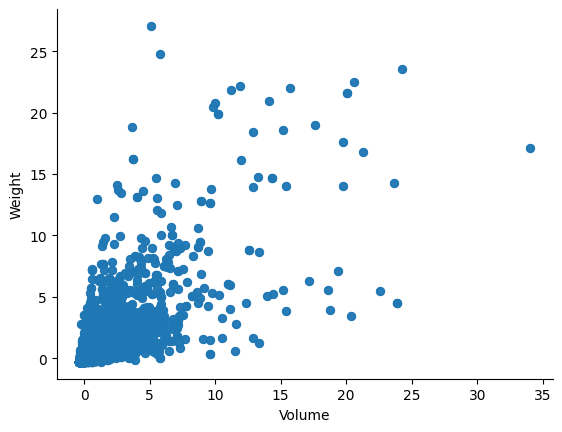

In [9]:
# @title Volume vs Weight
final_df.plot(kind='scatter', x='Volume', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Видна линейная зависимость между весом и объёмов. Удалять эти признаки не будет т.к. есть гипотеза о том, что может существовать их совместное влиение вместе с другими признаками на тергет. Остальные просмотренные соотношения признаков не представляются интересными.

## Сохраняем scaler для использования при нормализации тестовых данных

In [ ]:
with open('scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

# <a id="4">Создание бинарного целевого признака</a>

### Таргет percent_nClick это частота клиента перехода по ссылке. Её можно бинаризовать и перейти к задаче классификации. Для этого нужно подобрать порог отнесения к 1 или 0 классу. Построим график отнесения наблюдения к 1 или 0 классу в зависимости от подбираемого порога.

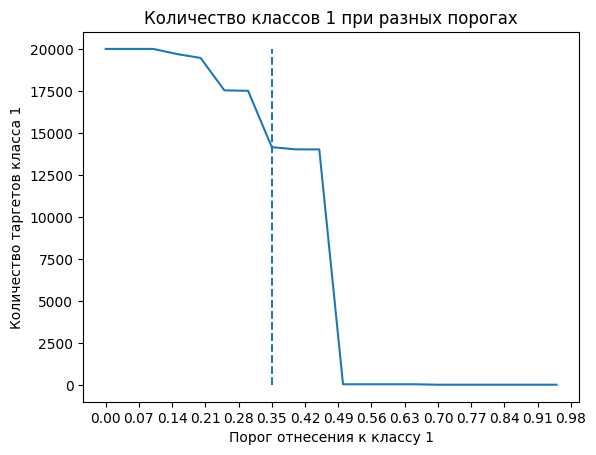

In [10]:
# Инициализируем списки для хранения значений количества классов 1 и порогов
ones = []
thresh_lst = []

# Проходим по порогам от 0 до 1 с шагом 0.05
for thresh in np.arange(0, 1, 0.05):
    # Бинаризуем значения 'percent_nClick' по текущему порогу
    bin_values = final_df['percent_nClick'].map(lambda x: 1 if x > thresh else 0).value_counts()
    # Сохраняем количество значений, отнесенных к классу 1
    ones.append(bin_values.get(1, 0))  # добавил значение по умолчанию 0, если нет значений класса 1
    # Сохраняем текущий порог
    thresh_lst.append(thresh)

# Строим график зависимости количества классов 1 от порога
plt.plot(thresh_lst, ones)
# Добавляем метку оси X
plt.xlabel("Порог отнесения к классу 1")
# Добавляем метку оси Y
plt.ylabel("Количество таргетов класса 1")
# Добавляем заголовок графика
plt.title("Количество классов 1 при разных порогах")
# Устанавливаем метки по оси X с шагом 0.07
plt.xticks(np.arange(0, 1, 0.07))
# Добавляем вертикальную линию при пороге 0.35
plt.vlines(ymin=0, ymax=max(ones), x=0.35, linestyles='dashed')
# Отображаем график
plt.show()

### Похоже, что ключевой точкой является порог в районе 0.35. Его выберем пока что как порог.

In [ ]:
final_df['BinNclick'] = final_df['percent_nClick'].map(lambda x: 1 if x>0.35 else 0)
final_df.head(3)

,OKVED,nCount,Amount,Volume,Weight,UnitTypeCategory,ActivityArea,Service,Support,TransportationType,ResponseDays,BeginMonth,EndMonth,IsHoliday,IsWeekend,percent_nClick,BinNclick
0,467306.0,-0.181508,-0.148895,-0.279925,-0.292518,2,1.0,0.0,0.0,0.0,-0.104964,7,7,0,0,0.0,0
1,467306.0,-0.181508,-0.148895,-0.077765,-0.292518,2,2.0,0.0,0.0,0.0,-0.104964,2,2,0,0,0.0,0
2,467306.0,-0.156237,-0.148895,-0.178845,-0.292518,2,3.0,0.0,0.0,2.0,-0.104964,2,7,0,0,0.0,0


# <a id="5">Статистический анализ данных</a>

### Теперь перейдём к рассмотрению числовых признаков. Построим матрицу корреляции числовых признаков на обучаюещй выборке

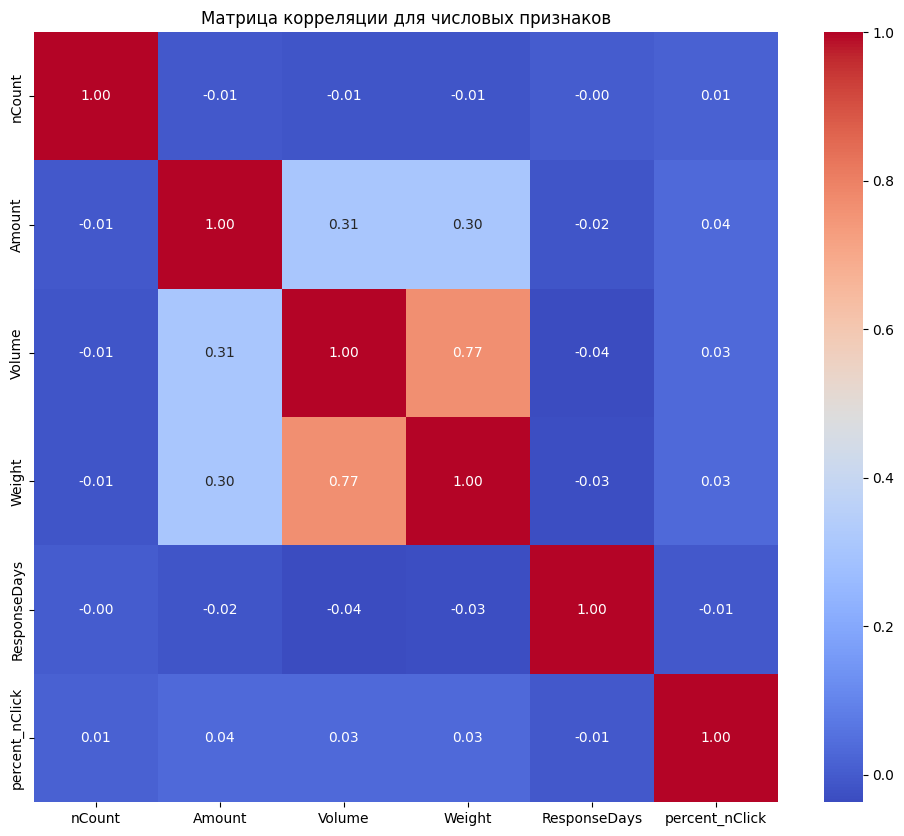

In [ ]:
# Вычисление корреляции между признаками
correlation_matrix = final_df.loc[:, numeric_columns + ['percent_nClick']].corr()

# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции для числовых признаков')
plt.show()

### Подверждается предположение о линейной зависимости между объёмом и весом. Но есть гипотеза, что эти признаки могут дать совокупный эффект с другими признакми, поэтому пока их оставим. Остльные признаки не коррелируют

# Проверка статистической значимости коэффициентов при числовых признаках в модель логистической регрессии

In [ ]:
df_numeric = final_df.loc[:, numeric_columns].drop('Volume', axis  =  1)
X, y = df_numeric,   final_df.loc[:, 'BinNclick']

# Инициализация логистической регрессии
logit_model = sm.Logit(y, X)

# Подгонка модели
result = logit_model.fit()

# Вывод результатов
print(result.summary())

# Отбор признаков с использованием критерия Акаике
selected_features = X.columns[np.where(result.pvalues < 0.05)[0]]
print("Признаки с низким значением p:", selected_features)

Optimization terminated successfully.
         Current function value: 0.692275
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              BinNclick   No. Observations:                66859
Model:                          Logit   Df Residuals:                    66855
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 May 2024   Pseudo R-squ.:                 -0.3410
Time:                        17:40:38   Log-Likelihood:                -46285.
converged:                       True   LL-Null:                       -34514.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
nCount           0.0242      0.008      2.929      0.003       0.008       0.040
Amount           0.0688

 Похоже, что 3 из 4 числовых признаков имеют статистическую значимость

# <a id="6">Отбор признаков</a>

### Проводим OneHotEncoding для категориальных данных

In [ ]:
# Создаем таблицу с фиктивными переменными для категориальных колонок
# Метод get_dummies() преобразует категориальные данные в бинарные фиктивные переменные (dummy variables)
dummie_table = pd.get_dummies(final_df[categorical_columns]).astype(int)

# Объединяем числовые колонки и таблицу с фиктивными переменными в один DataFrame
# Используем pd.concat() для объединения по горизонтали (axis=1)
dummie_table = pd.concat([final_df[numeric_columns], dummie_table], axis=1)

In [ ]:
len(dummie_table.columns) #количество признаков + 2 таргета

1157

всего получилось 1155 признаков

### Проверка гипотезы о возможности отбора признаков при помощи информационного критерия Акайке и модели логистической регрессии

In [ ]:
# Определяем переменную X как таблицу с фиктивными переменными и числовыми данными
X = dummie_table

# Определяем целевую переменную y как колонку 'BinNclick' из исходного DataFrame
y = final_df['BinNclick']

# Пытаемся выполнить обратный отбор признаков (backward selection) с использованием логистической регрессии
try:
    final_vars, iterations_logs = ss.backwardSelection(X, y, model_type="logistic")
# Обрабатываем исключение в случае возникновения ошибки, например, из-за сингулярной матрицы
except BaseException:
    print('Ошибка: сингулярная матрица')

Character Variables (Dummies Generated, First Dummies Dropped): []


c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
Ошибка: сингулярная матрица


Вывод: модель выдала ошибку о сингулярности матрицы. Значит данные взаимозависимы. Это неудивительно, учитывая большое количество бинарных признаков, которые завиясят друг от друга. Такая модель не подходит, надо искать другой способ отбора признаков

### Отбор признаков при помощи Деревье решений. Поскольку есть 2 таргета (бинарный и вещественный) можно построить деревья классификации и регрессии и отобрать признаки по их важности

In [ ]:
# Определяем переменную X как таблицу с фиктивными переменными и числовыми данными
X = dummie_table

# Определяем целевую переменную y как колонку 'BinNclick' из исходного DataFrame
y = final_df['BinNclick']

# Определяем вероятностную целевую переменную y_prob как колонку 'percent_nClick' из исходного DataFrame
y_prob = final_df['percent_nClick']

In [ ]:
# Разделяем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель случайного леса с 30 деревьями и фиксированным значением random_state для воспроизводимости результатов
clf = RandomForestClassifier(n_estimators=30, random_state=42)

# Обучаем модель на обучающей выборке
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

In [ ]:
# Создаем модель случайного леса для регрессии с 30 деревьями и фиксированным значением random_state для воспроизводимости результатов
reg = RandomForestRegressor(n_estimators=30, random_state=42)

# Обучаем модель на обучающей выборке
reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [ ]:
print('Тоность классификатора:', accuracy_score(clf.predict(X_test), y_test))
print('MAE регрессора:', mean_absolute_error(reg.predict(X_test), y_test))

Тоность классификатора: 0.9015106192043075
MAE регрессора: 0.11765247383674166


Вывод: деревья показали неплохие метрики, поэтому можно положиться на них в вопросе отбора признаков.

### На основе информационного критерия Джини смотрим важность признаков для деревьев классификации и регрессии


In [ ]:
# Встроенная важность признаков (Gini Importance) для классификатора
importances = clf.feature_importances_

# Создаем DataFrame для отображения важности признаков
feature_imp_df_cl = pd.DataFrame({'Feature': dummie_table.columns.to_list(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)

# Выводим DataFrame с важностью признаков для классификатора
print(feature_imp_df_cl)

# Встроенная важность признаков (Gini Importance) для регрессора
importances = reg.feature_importances_

# Создаем DataFrame для отображения важности признаков
feature_imp_df_reg = pd.DataFrame({'Feature': dummie_table.columns.to_list(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)

# Выводим DataFrame с важностью признаков для регрессора
print(feature_imp_df_reg)

             Feature  Gini Importance
1             Amount         0.098374
0             nCount         0.055245
3             Weight         0.054565
2             Volume         0.048150
101   OKVED_139909.0         0.014382
...              ...              ...
310   OKVED_353000.0         0.000000
1119    Service_44.0         0.000000
747   OKVED_712003.0         0.000000
66    OKVED_107239.0         0.000000
736   OKVED_711101.0         0.000000

[1157 rows x 2 columns]
            Feature  Gini Importance
1            Amount         0.124517
3            Weight         0.072030
0            nCount         0.053425
2            Volume         0.049043
101  OKVED_139909.0         0.015305
..              ...              ...
636  OKVED_521000.0         0.000000
637  OKVED_521003.0         0.000000
638  OKVED_521009.0         0.000000
641  OKVED_521101.0         0.000000
578  OKVED_477201.0         0.000000

[1157 rows x 2 columns]


### График важности признаков (первые 20 признаков по важности)

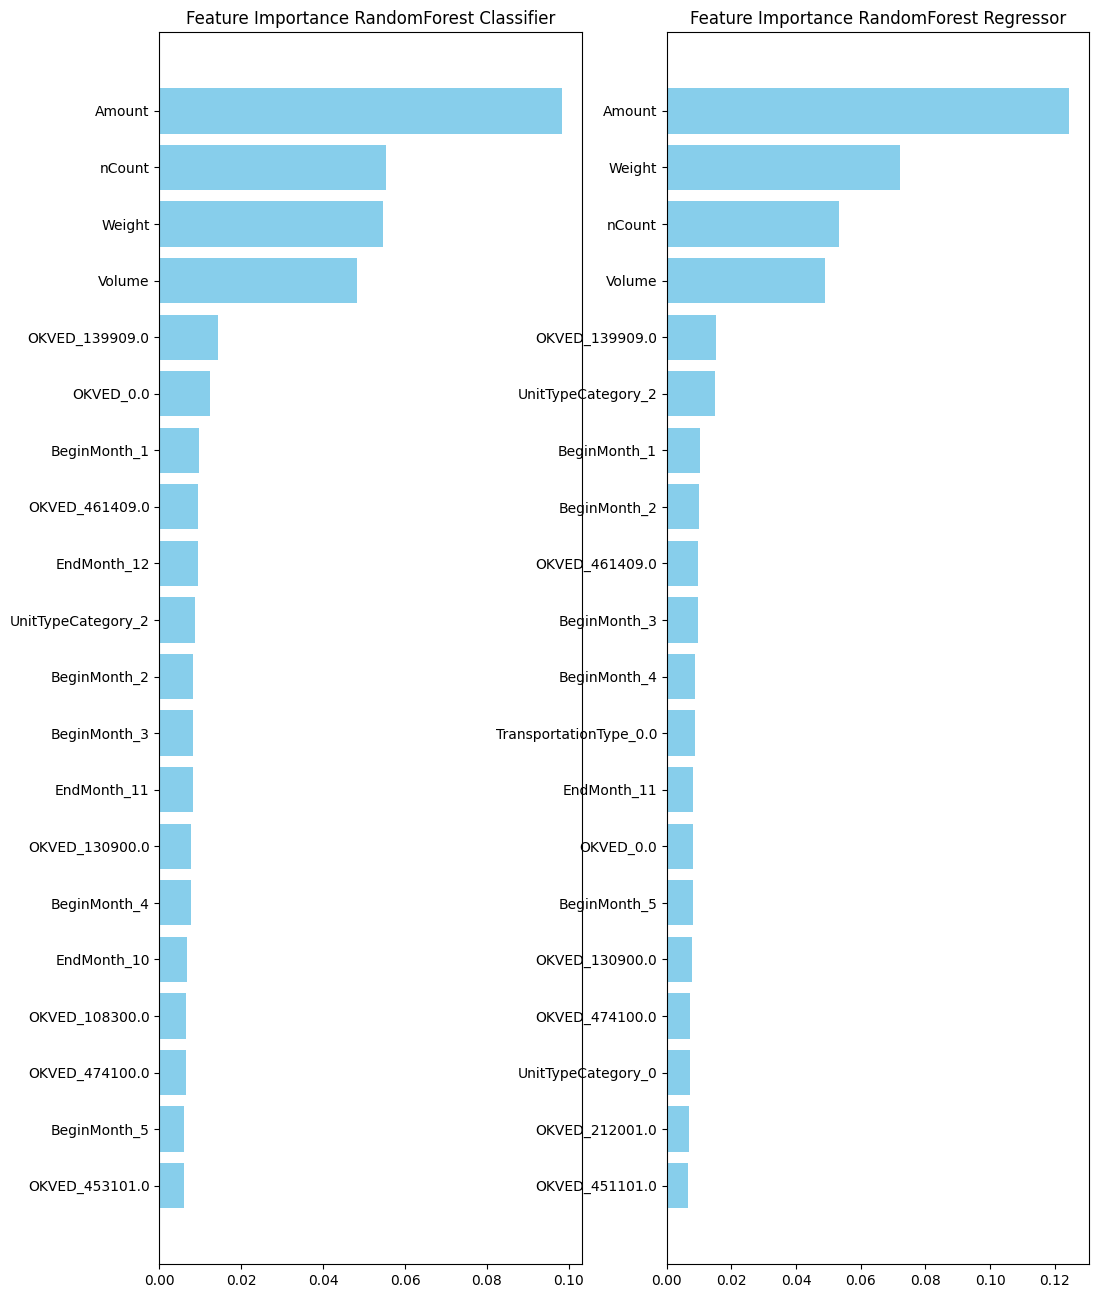

In [ ]:
# Создадим графики для отображения признаков по важности
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(1, 2, 1)
ax.barh(feature_imp_df_cl['Feature'][:20], feature_imp_df_cl['Gini Importance'][:20], color='skyblue')
#ax.xlabel('Gini Importance')
plt.title('Feature Importance RandomForest Classifier')
fig.gca().invert_yaxis()  # Invert y-axis for better visualization


ax = fig.add_subplot(1, 2, 2)
ax.barh(feature_imp_df_reg['Feature'][:20], feature_imp_df_reg['Gini Importance'][:20], color='skyblue')
#ax.xlabel('Gini Importance')
plt.title('Feature Importance RandomForest Regressor')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

можно отобрать признаки, важность которых больше некоторого порога и сохранить соответсвующую таблицу.

In [ ]:
# Отбираем признаки с важностью (Gini Importance) больше 0.001
important_features = feature_imp_df_cl[feature_imp_df_cl['Gini Importance'] > 0.001]['Feature']

# Выводим количество отобранных важных признаков
print(f'Количество признаков {len(important_features)}')

Количество признаков 198


In [ ]:
# Создаем новый DataFrame, содержащий только важные признаки, а также целевые переменные 'BinNclick' и 'percent_nClick'
selected_data = pd.concat([dummie_table[important_features], final_df['BinNclick'], final_df['percent_nClick']], axis=1)

# Сохраняем полученный DataFrame в CSV файл
selected_data.to_csv(r'raw_selected_data.csv')

### В итоге получилось 198 признаков.  2 последние колонки это таргеты:
*   BinNclick - 1 если клиент классифицируется как часто переходящий по ссылке, 0 наооборот
*   percent_nClick - частота перехода клиента по ссылке

In [ ]:
selected_data.head()

,Amount,nCount,Weight,Volume,OKVED_139909.0,OKVED_0.0,BeginMonth_1,OKVED_461409.0,EndMonth_12,UnitTypeCategory_2,...,OKVED_281300.0,OKVED_471100.0,ActivityArea_1.0,OKVED_472900.0,ActivityArea_75.0,OKVED_464400.0,ActivityArea_131.0,OKVED_422202.0,BinNclick,percent_nClick
0,-0.148895,-0.181508,-0.292518,-0.279925,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0.0
1,-0.148895,-0.181508,-0.292518,-0.077765,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
2,-0.148895,-0.156237,-0.292518,-0.178845,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
3,-0.148895,-0.181508,-0.292518,-0.279925,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0.0
4,-0.148895,-0.181508,-0.292518,-0.077765,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


# <a id="7">Создание эмбединга признаков</a>

Для создания эмбеддинга будем использовать простые Encoder и Decoder, которые напсианы в utils.py. Из выборке удаляем колонки IsHoliday_0 и IsWeekend_0, потому что они представляются собй полную противополоджность колонок IsHoliday_1 и IsWeekend_1, поэтому бесмысленны.

In [ ]:
# Разделяем данные на обучающую и тестовую выборки, удаляя колонки 'IsHoliday_0' и 'IsWeekend_0', так как они противоположны колонкам 'IsHoliday_1' и 'IsWeekend_1'
X_train, X_test, y_train, y_test = train_test_split(
    dummie_table.drop(['IsHoliday_0', 'IsWeekend_0'], axis=1),  # Удаляем ненужные колонки
    final_df['percent_nClick'],  # Целевая переменная
    test_size=0.05,  # 5% данных используем для тестирования
    random_state=42  # Фиксируем random_state для воспроизводимости
)

# Создаем TensorDataset для обучающей выборки
dataset = TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
# Создаем DataLoader для обучающей выборки с batch_size 64 и перемешиванием данных
train_DataLoader = DataLoader(dataset, batch_size=64, shuffle=True)

# Создаем TensorDataset для тестовой выборки
dataset = TensorDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))
# Создаем DataLoader для тестовой выборки с batch_size 64 без перемешивания данных
test_DataLoader = DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
# Инициализация модели
hidden_state = 64
num_features = np.shape(X_train)[1]
encoder = Encoder(num_input_features= num_features, num_output_features = hidden_state)
decoder = Decoder(num_input_features=hidden_state, num_output_features=num_features)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0005)
epoch_train_loss, epoch_test_loss = [], []
# Обучение модели
for epoch in tqdm.tqdm(range(6), 'Эпохи'):
    encoder.train()
    decoder.train()
    train_loss, test_loss  = [], []
    for batch in train_DataLoader:
        x = batch[0]
        optimizer.zero_grad()
        encoded = encoder(x.float())
        decoded = decoder(encoded)
        loss = criterion(decoded, x.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    encoder.eval()
    decoder.eval()
    for batch in test_DataLoader:
        x = batch[0]
        with torch.no_grad():
            encoded = encoder(x.float())
            decoded = decoder(encoded)
        loss = criterion(decoded, x.float())
        test_loss.append(loss.item())
    epoch_train_loss.append(np.mean(train_loss))
    epoch_test_loss.append(np.mean(test_loss))

Эпохи: 100%|██████████| 6/6 [02:47<00:00, 27.86s/it]


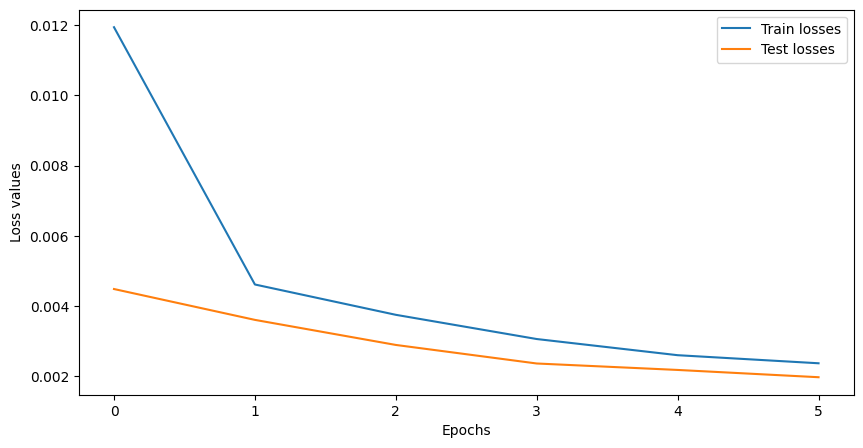

In [ ]:
# Создаем фигуру с размерами 10 на 5 дюймов
fig = plt.figure(figsize=(10, 5))

# Строим график потерь на тренировке
plt.plot(epoch_train_loss, label='Train losses')

# Строим график потерь на тестировании
plt.plot(epoch_test_loss, label='Test losses')

# Добавляем легенду
plt.legend()

# Называем оси
plt.xlabel('Epochs')
plt.ylabel('Loss values')

# Показываем график
plt.show()

Потери у сети снижаются, значит он восстанавливает данные из скрытого представления. Значит скрытое представление размерности 64 отражает суть данных. Такое векторное представление таблицы можно использовать как признаки. Иными словами, пусть сеть сама решает какие признаки стоит использовать, а какие нет и в какой степени.

In [ ]:
torch.save(encoder, 'encoder_model.pt') #сохраняем модель

In [ ]:
# Сохраняем dummie_table как таблицу из эмбеддингов
# Загружаем предобученную модель Encoder
model = torch.load(r'utils/encoder_model.pt')
model.eval()  # Переводим модель в режим оценки

# Создаем TensorDataset из dummie_table без последних двух колонок и целевых переменных
dataset = TensorDataset(
    torch.tensor(dummie_table.iloc[:, :-2].values),  # Входные данные для эмбеддинга
    torch.tensor(final_df[['percent_nClick', 'BinNclick']].values)  # Целевые переменные
)

# Создаем DataLoader для всего набора данных с batch_size 32 без перемешивания
all_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Инициализируем списки для хранения эмбеддингов и меток
all_vectors, all_labels = [], []

# Проходим по батчам данных в DataLoader
for batch in all_dataloader:
    x = batch[0]  # Входные данные
    y = batch[1].detach().numpy()  # Целевые переменные
    embedding = model(x.float())  # Получаем эмбеддинги из модели
    all_vectors.append(embedding.detach().numpy())  # Сохраняем эмбеддинги
    all_labels.append(y)  # Сохраняем метки

# Создаем DataFrame из эмбеддингов
embedding_df = pd.DataFrame(
    np.concatenate(all_vectors), 
    columns=[f'feature_{i}' for i in range(hidden_state)]  # Названия колонок для эмбеддингов
)

# Создаем DataFrame из меток
labels_df = pd.DataFrame(
    np.concatenate(all_labels), 
    columns=['percent_nClick', 'BinNclick']  # Названия колонок для меток
)

# Объединяем эмбеддинги и метки в один DataFrame
final_embedding_df = pd.concat([embedding_df, labels_df], axis=1)

Таблица преобразованная в эмбеддинги выглядит так:

In [ ]:
final_embedding_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,percent_nClick,BinNclick
0,-0.331746,-3.457138,0.125102,1.021463,2.472393,2.566365,1.332137,2.003790,1.629643,1.988239,...,-3.085047,-0.224229,0.271834,1.150964,-0.437560,2.302062,0.724630,2.088537,0.0,0.0
1,-0.760387,-2.433104,2.148351,2.141187,1.686539,1.412063,3.730581,1.293363,0.712259,1.832634,...,-3.748603,0.207825,0.666451,2.040472,-1.574180,2.136939,-0.291978,-0.196457,0.0,0.0
2,-1.273467,0.056620,1.844341,0.993846,0.568709,3.994567,3.033117,-0.178665,-0.666688,-0.546674,...,0.782387,-5.887007,-1.785824,-3.722951,-5.684657,1.169104,-1.951936,-2.048238,0.0,0.0
3,-0.235222,-1.081148,0.286984,0.808517,1.195306,3.188333,1.210665,2.051494,0.862255,2.662023,...,-0.113559,-2.164554,0.407967,-0.552224,-1.559123,1.198165,-0.345436,2.045499,0.0,0.0
4,-0.834875,0.038956,2.473953,1.657729,0.030935,1.591627,3.866596,1.418826,-0.297197,2.170367,...,-0.805988,-1.887454,0.055080,0.089022,-2.977000,0.637381,-1.487314,-0.554593,0.0,0.0


In [ ]:
final_embedding_df.to_csv('embdedding_features.csv') #сохраняем обучающую выборку в форме эмбеддингов

### Определяем функцию, которая переводит таблицу из формата предообратонной таблицы behaviour_2023_preprocessed в эмбеддинги

In [54]:
def df_to_embed(df):
    ''''Функция преобразует признаки таблицы behavior в эмбеддинги.
        df - pd.DataFrame с такими же признаками как и behaviour_2023_preprocessed.csv

        return pd.DataFrame - таблица с эмбедингами без таргета'''

    numeric_columns = ['nCount', 'Amount', 'Volume', 'Weight', 'ResponseDays']
    categorical_columns = ['OKVED', 'UnitTypeCategory', 'ActivityArea', 'Service',
                       'Support', 'TransportationType', 'BeginMonth', 'EndMonth',
                       'IsHoliday', 'IsWeekend']

    encoder = torch.load(r'utils/encoder_model.pt')
    num_features = encoder.fc2.out_features

    with open('utils/dummie_columns.pickle', 'rb') as file:
        col_names = pickle.load(file)

    tmp = pd.DataFrame(data = None, columns=col_names)

    df = categorize_table(df).drop([ 'UID'], axis = 1)
   # df = df.drop('UID', axis = 1)

    with open('utils/scaler.pickle', 'rb') as file:
         scaler = pickle.load(file)

    df.loc[:, numeric_columns] = scaler.transform(df.loc[:, numeric_columns])

    dummie_table = pd.get_dummies(df[categorical_columns]).astype(int)
    dummie_table = pd.concat([df[numeric_columns], dummie_table],  axis=  1)
    
    ['IsHoliday_0', 'IsWeekend_0', 'ActivityArea_0']

    final_df = pd.concat([tmp, dummie_table], axis = 0).drop(['IsHoliday_0', 'IsWeekend_0'], axis = 1)
    for missed_col in ['IsHoliday_0', 'IsWeekend_0', 'ActivityArea_0']:
        if missed_col in final_df:
            final_df = final_df.drop(missed_col, axis = 1)
    final_df = final_df.fillna(0)

    #сохраняем dummie_table как таблицу из эмбеддингов
    all_vectors = []
    for row in final_df.iterrows():
        x = torch.tensor(row[1].values).unsqueeze(0)
        embedding = encoder(x.float())
        all_vectors.append(embedding.detach().numpy())
    embedding_df = pd.DataFrame(np.concatenate(all_vectors), columns=[f'feature_{i}' for i in range(num_features)])
    print('Преобразование в эмбеддинги завершено')
    return embedding_df

загружаем таблицу и берём 20 строк

In [55]:
behaviour = pd.read_csv(r'../preprocessed/behaviour_2023_preprocessed.csv')
df = behaviour.iloc[10:30, :]

применяем функцию df_to_embed и выводим результат

In [56]:
df_embedings = df_to_embed(df)
df_embedings.head(3)

c:\Users\Mikhail\Desktop\крипты мфти\проектный практикум\mipt_datatons\target_customer_segment\feature_selection\utils\utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviour.loc[:, 'OKVED'] = behaviour['OKVED'].map(lambda x: 0 if pd.isna(x) else x) #.astype("category")
c:\Users\Mikhail\Desktop\крипты мфти\проектный практикум\mipt_datatons\target_customer_segment\feature_selection\utils\utils.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviour.loc[:, 'ActivityArea'] = behaviour['Acti

Преобразование в эмбеддинги завершено


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,-1.879712,-0.062494,1.219812,-0.942602,0.901811,-0.921155,1.409124,0.471208,0.706856,-0.516168,...,-2.483780,0.441799,-1.772649,0.196960,2.635578,1.236344,0.130977,2.292270,1.712600,0.297776
1,-1.189257,-0.421894,-0.195553,0.173048,2.774388,-0.506277,1.385067,-0.374000,0.126479,-0.702917,...,-0.083395,0.549440,-1.744801,-0.349327,2.434678,2.434294,0.040048,1.559436,2.119968,-0.344434
2,-1.762193,-0.801992,-0.257771,-1.236851,0.628606,0.769811,0.027066,-0.694934,0.775178,-0.763566,...,-0.822053,0.746517,-2.581679,0.009575,2.076722,2.623639,0.967002,1.756314,0.257418,0.522938


теперь таблица преобразована в эмбеддинги

# <a id="8">Выводы</a>

* Гипотеза о возможности создания таргета за счёт кластеризации не подтвердилась
* В качестве таргета создан признак percent_nClick, который означает частоту перехода клиента по ссылке.
* Из признака percent_nClick создан бинарный признак BinNclick, имеющий значение 1, если клиент перейдёт по ссылке, и 0 если нет
* Анализ статистической значимости коэффициентов логистической регресси показал значимое отличие коэффициентов числовых признаков от 0
* Отбор признаков по критерию Акайке и логистической регрессией не увенчался успехом, поскольку матрица данных оказалась сингулярной
* Проведён отбор отбор признаков по их важности с использованием информационного критерия Джини для бэггинга деревьев. Регрессионное и классифицирующее деревья для числового и бинарного признаков показали одинаковый результат.
* Из 1155 полученных в результате OneHotEncoding признаков было отобрано 198 за счёт важности признака, полученного от использования деревьев решений. Эти данные сохранены в feature_selection\data\raw_selected_data.csv  Последние две колонки это таргет: percent_nClick и BinNclickBinNclick
* Классчиские методы понижегния размерности (например, PCA) не подходят для матрицы данных ввиду скореллированности признаков и большого количества категориальных данных.
* Построена и обучена полносвязанная нейронная сеть по типо энкодер-декодер, которая возвращает эмбеддинг размерности  64 из таблицы данных, полученной в результате преобразования OneHotEncoding (из 1155 признаков в 64). Преобразованные в эмбеддинги данные сохранены в feature_selection\data\embdedding_features.csv Последние две колонки это таргет: percent_nClick и BinNclickBinNclick